### Import Library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.callbacks import EarlyStopping
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

### Load Data

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/Glucofy-Team/Glucofy-Machine-Learning/main/data/nutrition%20food%20dataset%20-%20modified.csv')
data

,category,name,glycemic_index,glycemic_load,calories (kcal),proteins (g),carbohydrates (g),fats (g)
0,Lainnya,Ragi,35.0,6.3,105.0,8.0,18.0,1.9
1,Lainnya,Ragi bir,35.0,0.0,75.0,12.7,0.0,2.7
2,Lainnya,Maltodekstrin,95.0,94.0,380.0,0.0,99.0,0.0
3,Lainnya,Palm pulp,20.0,1.2,354.0,3.4,6.2,33.5
4,Lainnya,Telur dadar,49.0,7.3,210.0,14.0,15.0,2.1
...,...,...,...,...,...,...,...,...
564,Kue dan roti,Roti Pumpernickel,45.0,21.6,250.0,9.0,48.0,3.1
565,Kue dan roti,Roti Beras,70.0,48.0,306.0,6.3,68.6,0.7
566,Kue dan roti,Roti dedak,65.0,29.4,227.0,7.0,45.2,1.3
567,Kue dan roti,Roti labu,40.0,17.0,211.0,5.5,42.6,2.4


### Preprocessing Data

In [ ]:
def categorize_gl_new(gl):
    if gl <= 10:
        return 'Low'
    elif gl <= 19:
        return 'Medium'
    else:
        return 'High'

data['gl_category'] = data['glycemic_load'].apply(categorize_gl_new)

- Separate numeric features and target variables.

In [ ]:
numeric_features = ['calories (kcal)', 'proteins (g)', 'carbohydrates (g)', 'fats (g)', 'glycemic_index']
X = data[numeric_features]

y_gl = data['glycemic_load']
y_gl_category = data['gl_category']

- Using one hot encoding for category classification.

In [ ]:
label_encoder_gl = LabelEncoder()
y_gl_category_encoded = label_encoder_gl.fit_transform(y_gl_category)

In [ ]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_gl_category_onehot = onehot_encoder.fit_transform(y_gl_category_encoded.reshape(-1, 1))

In [ ]:
y_gl_array = y_gl.to_numpy()

In [ ]:
y_combined = np.column_stack((y_gl_category_onehot, y_gl_array))

- Split the data into training and test sets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_combined, test_size=0.1, random_state=42)

- Standardize the data to ensure the input features are balanced.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Build and Train Model

In [ ]:
input_shape = X_train.shape[1]

inputs = tf.keras.Input(shape=(input_shape,))

x = tf.keras.layers.Dense(32, activation='relu')(inputs)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

num_categories = y_gl_category_onehot.shape[1]
output1 = tf.keras.layers.Dense(num_categories, activation='softmax', name='category_output')(x)
output2 = tf.keras.layers.Dense(1, activation='relu', name='gl_output')(x)

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=[output1, output2])

y_train_category = y_train[:, :num_categories]
y_train_gl = y_train[:, num_categories]

y_test_category = y_test[:, :num_categories]
y_test_gl = y_test[:, num_categories]

In [ ]:
def adjust_learning_rate():

    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))

    optimizer = tf.keras.optimizers.Adam()

    model.compile(optimizer=optimizer,
              loss={'category_output': 'categorical_crossentropy', 'gl_output': 'huber_loss'},
              metrics={'category_output': 'accuracy', 'gl_output': 'mae'})

    history = model.fit(X_train_scaled,
                        {'category_output': y_train_category, 'gl_output': y_train_gl},
                        epochs=100,
                        callbacks=[lr_schedule],
                        verbose=0)

    return history

In [ ]:
lr_history = adjust_learning_rate()

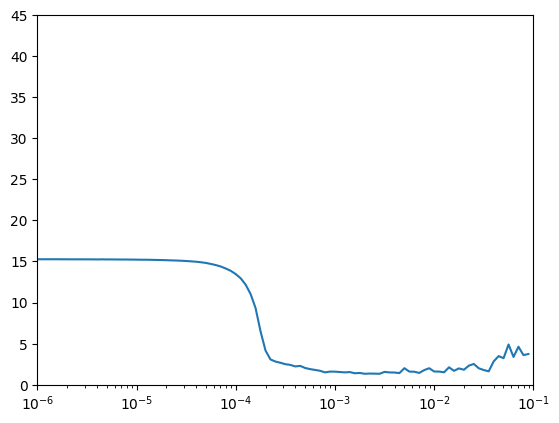

In [ ]:
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.axis([1e-6, 1e-1, 0, 45])
plt.show()

In [ ]:
model = tf.keras.Model(inputs=inputs, outputs=[output1, output2])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
              loss={'category_output': 'categorical_crossentropy', 'gl_output': 'huber_loss'},
              metrics={'category_output': 'accuracy', 'gl_output': 'mae'})

model.fit(
    X_train_scaled,
    {'category_output': y_train_category, 'gl_output': y_train_gl},
    epochs=75,
    validation_data=(X_test_scaled, {'category_output': y_test_category, 'gl_output': y_test_gl}),
    verbose=2)

Epoch 1/75
17/17 - 3s - loss: 2.7985 - category_output_loss: 0.4310 - gl_output_loss: 2.3675 - category_output_accuracy: 0.8918 - gl_output_mae: 2.7815 - val_loss: 2.4840 - val_category_output_loss: 0.3678 - val_gl_output_loss: 2.1161 - val_category_output_accuracy: 0.8475 - val_gl_output_mae: 2.5583 - 3s/epoch - 205ms/step
Epoch 2/75
17/17 - 0s - loss: 2.2402 - category_output_loss: 0.3682 - gl_output_loss: 1.8720 - category_output_accuracy: 0.9013 - gl_output_mae: 2.2841 - val_loss: 1.6264 - val_category_output_loss: 0.3217 - val_gl_output_loss: 1.3046 - val_category_output_accuracy: 0.8814 - val_gl_output_mae: 1.7070 - 125ms/epoch - 7ms/step
Epoch 3/75
17/17 - 0s - loss: 1.9997 - category_output_loss: 0.2611 - gl_output_loss: 1.7386 - category_output_accuracy: 0.9260 - gl_output_mae: 2.1457 - val_loss: 1.5787 - val_category_output_loss: 0.2507 - val_gl_output_loss: 1.3280 - val_category_output_accuracy: 0.8814 - val_gl_output_mae: 1.7507 - 220ms/epoch - 13ms/step
Epoch 4/75
17/17 - 

### Evaluate Model

In [ ]:
results = model.evaluate(X_test_scaled, {'category_output': y_test_category, 'gl_output': y_test_gl})

print(f"GL Category Accuracy: {results[3]:.4f}")
print(f"GL MAE: {results[4]:.4f}")

2/2 [==============================] - 0s 9ms/step - loss: 0.2873 - category_output_loss: 0.1332 - gl_output_loss: 0.1540 - category_output_accuracy: 0.9661 - gl_output_mae: 0.3927
GL Category Accuracy: 0.9661
GL MAE: 0.3927


In [ ]:
new_data = np.array([[391.0,	10.7,	27.0,	26.5, 35.0]])
new_data_scaled = scaler.transform(new_data)

new_prediction = model.predict(new_data_scaled)
gl_new_prediction = round((new_prediction[1])[0][0], 1)
gl_new_category = new_prediction[0]

category_index = np.argmax(gl_new_category, axis=1)
category_label = label_encoder_gl.inverse_transform(category_index)

print('Glycemic Load Prediction: ', gl_new_prediction)
print('Glycemic Load Category:', category_label[0])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 46ms/step
Glycemic Load Prediction:  9.2
Glycemic Load Category: Low


### Save Model

In [ ]:
model.save('Glycemic Load Model.h5')